In [2]:
!   wget https://stockfishchess.org/files/stockfish_14_linux_x64_popcnt.zip && \
    unzip stockfish_14_linux_x64_popcnt.zip stockfish_14_linux_x64_popcnt/stockfish_14_x64_popcnt

--2023-05-07 18:06:52--  https://stockfishchess.org/files/stockfish_14_linux_x64_popcnt.zip
Resolving stockfishchess.org (stockfishchess.org)... 104.25.158.9, 172.67.80.249, 104.25.159.9, ...
Connecting to stockfishchess.org (stockfishchess.org)|104.25.158.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28531469 (27M) [application/zip]
Saving to: ‘stockfish_14_linux_x64_popcnt.zip’

stockfish_14_linux_ 100%[===================>]  27.21M  13.3MB/s    in 2.0s    

2023-05-07 18:06:54 (13.3 MB/s) - ‘stockfish_14_linux_x64_popcnt.zip’ saved [28531469/28531469]

Archive:  stockfish_14_linux_x64_popcnt.zip
  inflating: stockfish_14_linux_x64_popcnt/stockfish_14_x64_popcnt  


In [1]:
!pip install python-chess==0.31.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 3.0 MB/s eta 0:00:00


In [3]:
import chess
import chess.engine
import random
import numpy

def random_board(max_depth=200):
  board = chess.Board()
  depth = random.randrange(0, max_depth)

  for _ in range(depth):
    all_moves = list(board.legal_moves)
    random_move = random.choice(all_moves)
    board.push(random_move)
    if board.is_game_over():
      break

  return board

def stockfish(board, depth):
  with chess.engine.SimpleEngine.popen_uci('/content/stockfish_14_linux_x64_popcnt/stockfish_14_x64_popcnt') as sf:
    result = sf.analyse(board, chess.engine.Limit(depth=depth))
    score = result['score'].white().score()
    return score

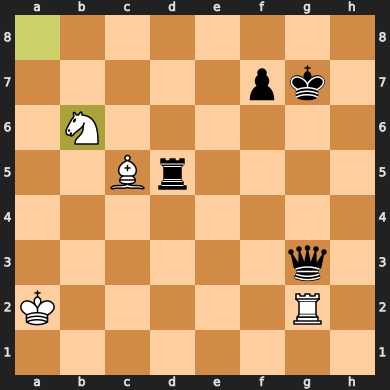

In [4]:
board = random_board()
board

In [5]:
print(stockfish(board, 10))

-6165


In [6]:
squares_index = {
    'a': 0,
    'b': 1,
    'c': 2,
    'd': 3,
    'e': 4,
    'f': 5,
    'g': 6,
    'h': 7
}

def square_to_index(square):
  letter = chess.square_name(square)
  return 8 - int(letter[1]), squares_index[letter[0]]

def split_dims(board):
  board3d = numpy.zeros((14,8,8), dtype=numpy.int8)

  for piece in chess.PIECE_TYPES:
    for square in board.pieces(piece, chess.WHITE):
      idx = numpy.unravel_index(square, (8, 8))
      board3d[piece - 1][7 - idx[0]][idx[1]] = 1
    for square in board.pieces(piece, chess.BLACK):
      idx = numpy.unravel_index(square, (8, 8))
      board3d[piece + 5][7 - idx[0]][idx[1]] = 1 

  aux = board.turn
  board.turn = chess.WHITE
  for move in board.legal_moves:
    i, j = square_to_index(move.to_square)
    board3d[12][i][j] = 1
  board.turn = chess.BLACK
  for move in board.legal_moves:
    i, j = square_to_index(move.to_square)
    board3d[13][i][j] = 1
  board.turn = aux

  return board3d

In [7]:
split_dims(board)

array([[[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        

In [8]:
from tempfile import TemporaryFile

boards = []
scores = []

for i in range(100000):
  board = random_board()
  score = stockfish(board, 10)
  if score == None:
    continue
  board = split_dims(board)
  boards.append(board)
  scores.append(score)
  print(i)

boards = numpy.array(boards)
scores = numpy.array(scores)

dataset = TemporaryFile()
numpy.savez(dataset, x=boards, y=scores)

Streaming output truncated to the last 5000 lines.
94378
94379
94380
94382
94383
94384
94385
94386
94387
94388
94389
94390
94391
94392
94393
94395
94396
94397
94398
94399
94400
94402
94404
94405
94407
94408
94410
94412
94413
94414
94415
94416
94417
94418
94419
94420
94421
94422
94423
94424
94425
94426
94427
94428
94429
94430
94431
94432
94433
94434
94435
94436
94437
94438
94440
94441
94442
94444
94446
94447
94448
94449
94450
94451
94452
94453
94454
94455
94456
94457
94458
94459
94460
94461
94462
94463
94464
94467
94468
94469
94470
94471
94472
94474
94476
94477
94478
94479
94480
94481
94482
94483
94484
94485
94486
94487
94488
94489
94491
94492
94493
94494
94496
94498
94500
94501
94502
94503
94506
94508
94509
94510
94512
94513
94514
94515
94516
94517
94519
94520
94521
94522
94523
94525
94526
94527
94528
94530
94531
94532
94533
94534
94535
94537
94538
94540
94542
94543
94544
94545
94546
94547
94548
94549
94550
94551
94552
94553
94554
94555
94556
94557
94558
94559
94560
94561
94562
94563
9

In [9]:
import keras.models as models
import keras.layers as layers
import keras.utils as utils
import keras.optimizers as optimizers

def build_model(conv_size, conv_depth):
  board3d = layers.Input(shape=(8,8,14))

  x = board3d
  for _ in range(conv_depth):
    x = layers.Conv2D(filters = conv_size, kernel_size=3, padding='same')(x)
  x = layers.Flatten()(x)
  x = layers.Dense(64, 'relu')(x)
  x = layers.Dense(1, 'sigmoid')(x)

  return models.Model(inputs = board3d, outputs=x)

def build_model_residaul(conv_size, conv_depth):
  x = layers.Conv2D(filters=conv_size, kernel_size=3, padding='same')
  

In [10]:
model = build_model(32,4)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8, 8, 14)]        0         
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 32)          4064      
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 32)          9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 32)          9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 32)          9248      
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 64)                131136

In [11]:
import keras.callbacks as callbacks

boards = numpy.array(boards)
scores = numpy.array(scores)

def get_dataset(boards,scores):
  scores = numpy.asarray(scores / abs(scores).max() / 2 + 0.5, dtype=numpy.float32)
  return boards, scores

x_train, y_train = get_dataset(boards, scores)
x_train = numpy.transpose(x_train, (0,2,3,1))
print(x_train.shape)
print(y_train.shape)

(88379, 8, 8, 14)
(88379,)


In [17]:
model.compile(optimizer=optimizers.Adam(1e-4), loss='mean_squared_error')
model.summary()
model.fit(x_train, y_train,
          batch_size=2048,
          epochs=500,
          verbose=1,
          validation_split=0.1,
          callbacks=[callbacks.ReduceLROnPlateau(monitor='loss', patience=10),
                     callbacks.EarlyStopping(monitor='loss', patience=15)])
model.save('chess.h5')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8, 8, 14)]        0         
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 32)          4064      
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 32)          9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 32)          9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 32)          9248      
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 64)                131136